# Topics in English Quran

In [1]:
import glob

from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem.lancaster import LancasterStemmer
# from nltk.cluster import KMeansClusterer, euclidean_distance
# from gensim import corpora, models, utils
from numpy import array
from gensim import corpora, models


In [7]:
import nltk
nltk.download()

showing info https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/index.xml


True

### Downloaded http://www.clearquran.com/

In [2]:
data_folder = '../data/quran-verse-by-verse-text/'

documents = [] # chapters->verses
for chapter in range(1, 115):
    files = sorted(glob.glob(data_folder + str(chapter).zfill(3) + '*'))
    verses = [open(f, 'r').read() for f in files]
    documents.append(verses)

In [3]:
# Remove non ascii and change to lower case; not necessary with RegexpTokenizer(r'\w+')
docs = [jj.decode('utf8').encode('ascii', errors='ignore').lower() for ii in documents for jj in ii]

In [30]:
# removing whitespaces, punctuations, stopwords, and stemming words
# https://gist.github.com/sangheestyle/8691435
processed = []
tokenizer = RegexpTokenizer(r'\w+')
stop = stopwords.words('english')

# Remove god and lord
# stop += ['god', 'lord']

for document in docs:
    intermediate = tokenizer.tokenize(document)    
    intermediate = [i for i in intermediate if i not in stop]
    # FIXME: using other stemmers also to know quality of each stemmed text
    lanste = LancasterStemmer()
    intermediate = [lanste.stem(i) for i in intermediate]
    processed.append(intermediate)

In [31]:
# making dictionary and corpus
dictionary = corpora.Dictionary(processed)
#dictionary.save('/tmp/dict.dict')
corpus = [dictionary.doc2bow(text) for text in processed]
#corpora.MmCorpus.serialize('/tmp/temp.mm', corpus)

In [32]:
# LDA modeling
lda = models.LdaModel(corpus, id2word=dictionary, num_topics=11, passes=10)
corpus_lda = lda[corpus] # create a double wrapper over the original corpus: bow->tfidf->fold-in-lsi

In [33]:
a = lda.print_topics(num_topics=-1, num_words=7)

In [34]:
for i in docs:
    if 'guard' in i:
        break

In [35]:
docs[:10]

['in the name of god, the gracious, the merciful.',
 'praise be to god, lord of the worlds.',
 'the most gracious, the most merciful.',
 'master of the day of judgment.',
 'it is you we worship, and upon you we call for help.',
 'guide us to the straight path.',
 'the path of those you have blessed, not of those against whom there is anger, nor of those who are misguided.',
 'in the name of god, the gracious, the merciful.',
 'alif, lam, meem.',
 'this is the book in which there is no doubt, a guide for the righteous.']

In [36]:
print docs[16:20], processed[16:20]

['they seek to deceive god and those who believe, but they deceive none but themselves, though they are not aware.', 'in their hearts is sickness, and god has increased their sickness. they will have a painful punishment because of their denial.', 'and when it is said to them, do not make trouble on earth, they say, we are only reformers.', 'in fact, they are the troublemakers, but they are not aware.'] [['seek', 'deceiv', 'god', 'believ', 'deceiv', 'non', 'though', 'aw'], ['heart', 'sick', 'god', 'increas', 'sick', 'pain', 'pun', 'den'], ['said', 'mak', 'troubl', 'ear', 'say', 'reform'], ['fact', 'troublemak', 'aw']]


In [37]:
print processed[:20]

[['nam', 'god', u'gracy', u'mercy'], ['pra', 'god', 'lord', 'world'], [u'gracy', u'mercy'], ['mast', 'day', 'judg'], ['wor', 'upon', 'cal', 'help'], ['guid', 'us', 'straight', 'path'], ['path', 'bless', 'ang', 'misguid'], ['nam', 'god', u'gracy', u'mercy'], ['al', 'lam', 'meem'], ['book', 'doubt', 'guid', 'right'], ['believ', 'unseen', 'perform', 'pray', 'giv', 'provid'], ['believ', 'rev', 'rev', 'certain', 'hereaft'], ['upon', u'guid', 'lord', 'success'], ['disbelieveit', 'wheth', 'warn', 'warn', 'themthey', 'believ'], ['god', 'set', 'seal', 'heart', 'hear', 'vis', 'veil', 'sev', 'tor'], ['among', 'peopl', 'say', 'believ', 'god', 'last', 'day', 'believ'], ['seek', 'deceiv', 'god', 'believ', 'deceiv', 'non', 'though', 'aw'], ['heart', 'sick', 'god', 'increas', 'sick', 'pain', 'pun', 'den'], ['said', 'mak', 'troubl', 'ear', 'say', 'reform'], ['fact', 'troublemak', 'aw']]


In [38]:
i = 0
print docs[i]
sorted_rel = sorted(corpus_lda[i], key=lambda x: x[1], reverse=True)
print sorted_rel[:3]
print a[sorted_rel[0][0]]
i += 1

in the name of god, the gracious, the merciful.
[(8, 0.81818055869925832), (3, 0.01818221397367864), (9, 0.018182209315607042)]
(8, u'0.135*"god" + 0.117*"mercy" + 0.096*"nam" + 0.088*"gracy" + 0.011*"pur" + 0.010*"success" + 0.010*"glory"')


In [39]:
a

[(0,
  u'0.084*"said" + 0.023*"us" + 0.023*"lif" + 0.020*"man" + 0.019*"two" + 0.018*"follow" + 0.016*"noth"'),
 (1,
  u'0.028*"on" + 0.024*"anoth" + 0.020*"sky" + 0.020*"every" + 0.020*"day" + 0.017*"sign" + 0.015*"see"'),
 (2,
  u'0.059*"day" + 0.027*"serv" + 0.017*"night" + 0.017*"cal" + 0.017*"hum" + 0.017*"rev" + 0.017*"lord"'),
 (3,
  u'0.089*"god" + 0.041*"ear" + 0.033*"cre" + 0.030*"heav" + 0.028*"lord" + 0.021*"giv" + 0.018*"everyth"'),
 (4,
  u'0.038*"lord" + 0.026*"peopl" + 0.022*"remind" + 0.020*"mos" + 0.019*"said" + 0.018*"night" + 0.016*"indee"'),
 (5,
  u'0.069*"know" + 0.037*"god" + 0.035*"say" + 0.027*"heart" + 0.023*"warn" + 0.022*"lord" + 0.020*"wil"'),
 (6,
  u'0.034*"god" + 0.033*"forg" + 0.032*"pun" + 0.028*"day" + 0.027*"lord" + 0.024*"believ" + 0.019*"whoev"'),
 (7,
  u'0.050*"us" + 0.040*"upon" + 0.025*"return" + 0.022*"land" + 0.022*"com" + 0.019*"fir" + 0.019*"lord"'),
 (8,
  u'0.135*"god" + 0.117*"mercy" + 0.096*"nam" + 0.088*"gracy" + 0.011*"pur" + 0.010*"

# word cloud

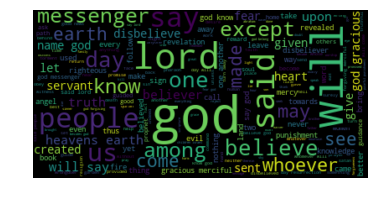

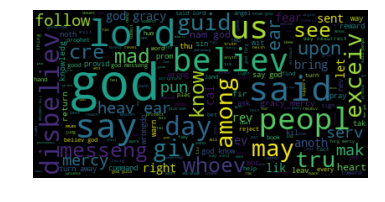

In [45]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
%matplotlib inline

# Read the whole text.
text = ' '.join(docs)
# Generate a word cloud image
wordcloud = WordCloud().generate(text)
# lower max_font_size
wordcloud = WordCloud(max_font_size=60).generate(text)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

text = ' '.join([' '.join(ii) for ii in processed])
# Generate a word cloud image
wordcloud = WordCloud().generate(text)
# lower max_font_size
wordcloud = WordCloud(max_font_size=60).generate(text)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()